<a href="https://colab.research.google.com/github/ArtuomMerkulov/ArtuomMerkulov/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%80%D1%83%D0%BA%D0%B8_%D0%BE%D1%82_%D0%BF%D0%B0%D0%BB%D1%8C%D1%86%D0%B5%D0%B2_%D0%B4%D0%BE_%D0%B7%D0%B0%D0%BF%D1%8F%D1%81%D1%82%D1%8C%D1%8F_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация рук

## Загрузка картинок



In [ ]:
!unzip -q '/content/drive/MyDrive/Numpy/hands.zip' 

In [ ]:
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 8 # Задаем количество классов на изображении
directory = '/content/hands/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'original' # Название папки с файлами обучающей выборки
val_directory = 'masks' # Название папки с файлами проверочной выборки

### Оригинальные изображения



In [ ]:
train_images = [] 
val_images = [] 

cur_time = time.time()
for filename in sorted(os.listdir(directory + train_directory)): 
    train_images.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_images)) 

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory)):                 
    val_images.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))    
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_images)) 

Обучающая выборка загржуена. Время загрузки: 9.15c
Количество изображений:  1380
Проверочная выборка загржуена. Время загрузки: 6.08c
Количество изображений:  1380


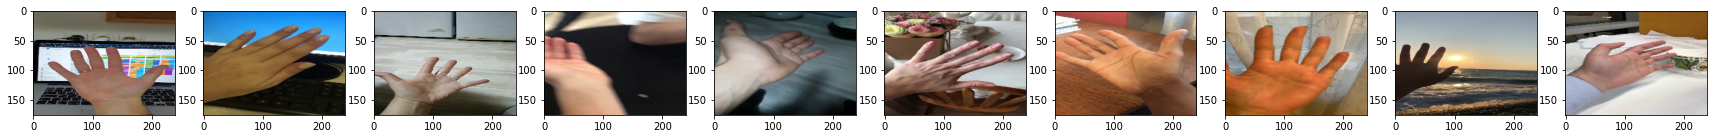

In [ ]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img) 
plt.show() 

### Сегментированные изображения

In [ ]:
train_segments = [] 
val_segments = [] 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory)): 
    train_segments.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_segments))

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory)):                                                     
    val_segments.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))     
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_segments))

Обучающая выборка загржуена. Время загрузки: 8.86c
Количество изображений:  1380
Проверочная выборка загржуена. Время загрузки: 5.97c
Количество изображений:  1380


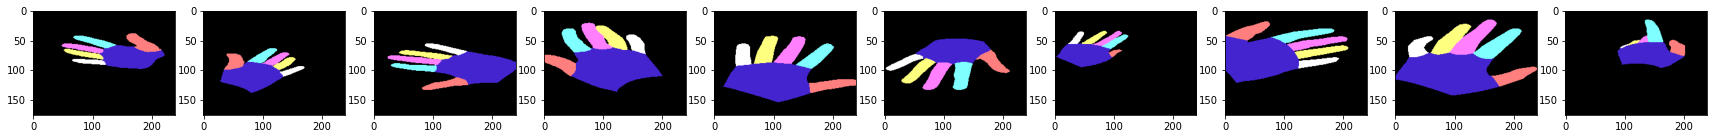

In [ ]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(val_segments) 
  axs[i].imshow(img) 
plt.show() 

### Создание выборки



In [ ]:
def color2index(color):
    index = -1
    if   (51>=color[0]>=0)   and (51>=color[1]>=0)  and (51>=color[2]>=0)  : index=0 # фон
    elif (130>=color[0]>=51)    and (130>=color[1]>=51)  and (260>=color[2]>=51)  : index=1 # ладонь
    elif (210>=color[0]>=51)    and (40>=color[1]>=0)  and (70>=color[2]>=0)    : index=2 # большой
    elif (127>=color[0]>=0)    and (255>=color[1]>=51)  and (255>=color[2]>=51)  : index=3 # указательный
    elif (255>=color[0]>=151) and (127>=color[1]>=51) and (255>=color[2]>=151) : index=4 # средний
    elif (255>=color[0]>=51)    and (255>=color[1]>=151) and (127>=color[2]>=51) : index=5 # безымянный
    elif (255>=color[0]>=51) and (255>=color[1]>=101) and (255>=color[2]>=51) : index=6 #мязинец
    else: index=7
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2) 
    color = []
    if   index == 0: color = [0, 0, 0]         # фон
    elif index == 1: color = [127, 127, 255]   # ладонь
    elif index == 2: color = [206, 36, 68]     # большой
    elif index == 3: color = [127, 255, 255]   # указательный
    elif index == 4: color = [255, 127, 255]   # средний
    elif index == 5: color = [255, 255, 127]   # безямянный 
    elif index == 6: color = [255, 255, 255]   # мязинец     
    elif index == 7: color = [127, 127, 127]   # остальное
    return color

In [ ]:
def rgbToohe(y, num_classes): 
    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3) 
    yt = [] 
    for i in range(len(y)): 
      yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    yt = np.array(yt) 
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) 
    return yt 

In [ ]:
def yt_prep(data, num_classes):
    yTrain = [] 
    for seg in data: 
        y = image.img_to_array(seg) 
        y = rgbToohe(y, num_classes)
        yTrain.append(y) 
        if len(yTrain) % 100 == 0: 
            print(len(yTrain)) 
    return np.array(yTrain) 

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(1380, 176, 240, 3)
(1380, 176, 240, 3)


In [ ]:
cur_time = time.time() 
yTrain = yt_prep(train_segments, num_classes)  
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Время обработки:  2215.85 c


In [ ]:
cur_time = time.time() 
yVal = yt_prep(val_segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

100
200
300
400
500
600
700
900
1000
1100
1200
1300


In [ ]:
yTrain.shape

(1380, 176, 240, 8)

In [ ]:
yVal.shape

(1380, 176, 240, 8)

## Модели


In [ ]:
def processImage(model, count = 1, n_classes = 8):
    indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(30, 15)) #Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    plt.show()  

### Линейная сегментирующая сеть



In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [ ]:
def linearSegmentationNet(num_classes = 7, input_shape = (176, 240, 3)):
    
    img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv3')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов
    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=[dice_coef])
    return model 

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) 
modelL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 240, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 176, 240, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 176, 240, 128)     0         
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 240, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 176, 240, 64)     256       
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) 
history = modelL.fit(xTrain, yTrain, epochs=10, batch_size=56, validation_data=(xVal, yVal)) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
25/25 [==============================] - 864s 35s/step - loss: 0.7922 - dice_coef: 0.5954 - val_loss: 3.2545 - val_dice_coef: 0.8016
Epoch 2/10
25/25 [==============================] - 862s 35s/step - loss: 0.3969 - dice_coef: 0.7657 - val_loss: 1.7693 - val_dice_coef: 0.8071
Epoch 3/10
25/25 [==============================] - 877s 35s/step - loss: 0.3314 - dice_coef: 0.8022 - val_loss: 1.1562 - val_dice_coef: 0.8210
Epoch 4/10
25/25 [==============================] - 872s 35s/step - loss: 0.2970 - dice_coef: 0.8205 - val_loss: 0.6422 - val_dice_coef: 0.8322
Epoch 5/10
25/25 [==============================] - 856s 34s/step - loss: 0.3171 - dice_coef: 0.8168 - val_loss: 0.5622 - val_dice_coef: 0.8391
Epoch 6/10
25/25 [==============================] - 860s 35s/step - loss: 0.3034 - dice_coef: 0.8242 - val_loss: 0.2966 - val_dice_coef: 0.8979
Epoch 7/10
25/25 [==============================] - 861s 35s/step - loss: 0.2510 - dice_coef: 0.8445 - val_loss: 0.3667 - val_dice_coef:

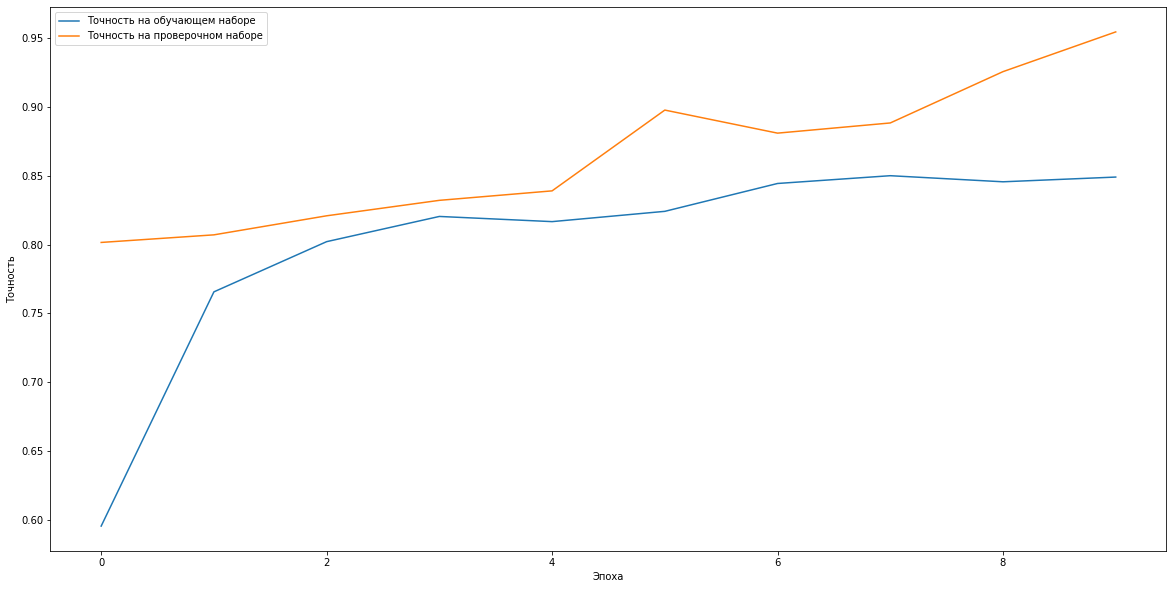

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.history['dice_coef'], label='Точность на обучающем наборе')
plt.plot(history.history['val_dice_coef'], label='Точность на проверочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [ ]:
modelL.save_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelL.h5')

## Распознавание

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) 
modelL.load_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelL.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


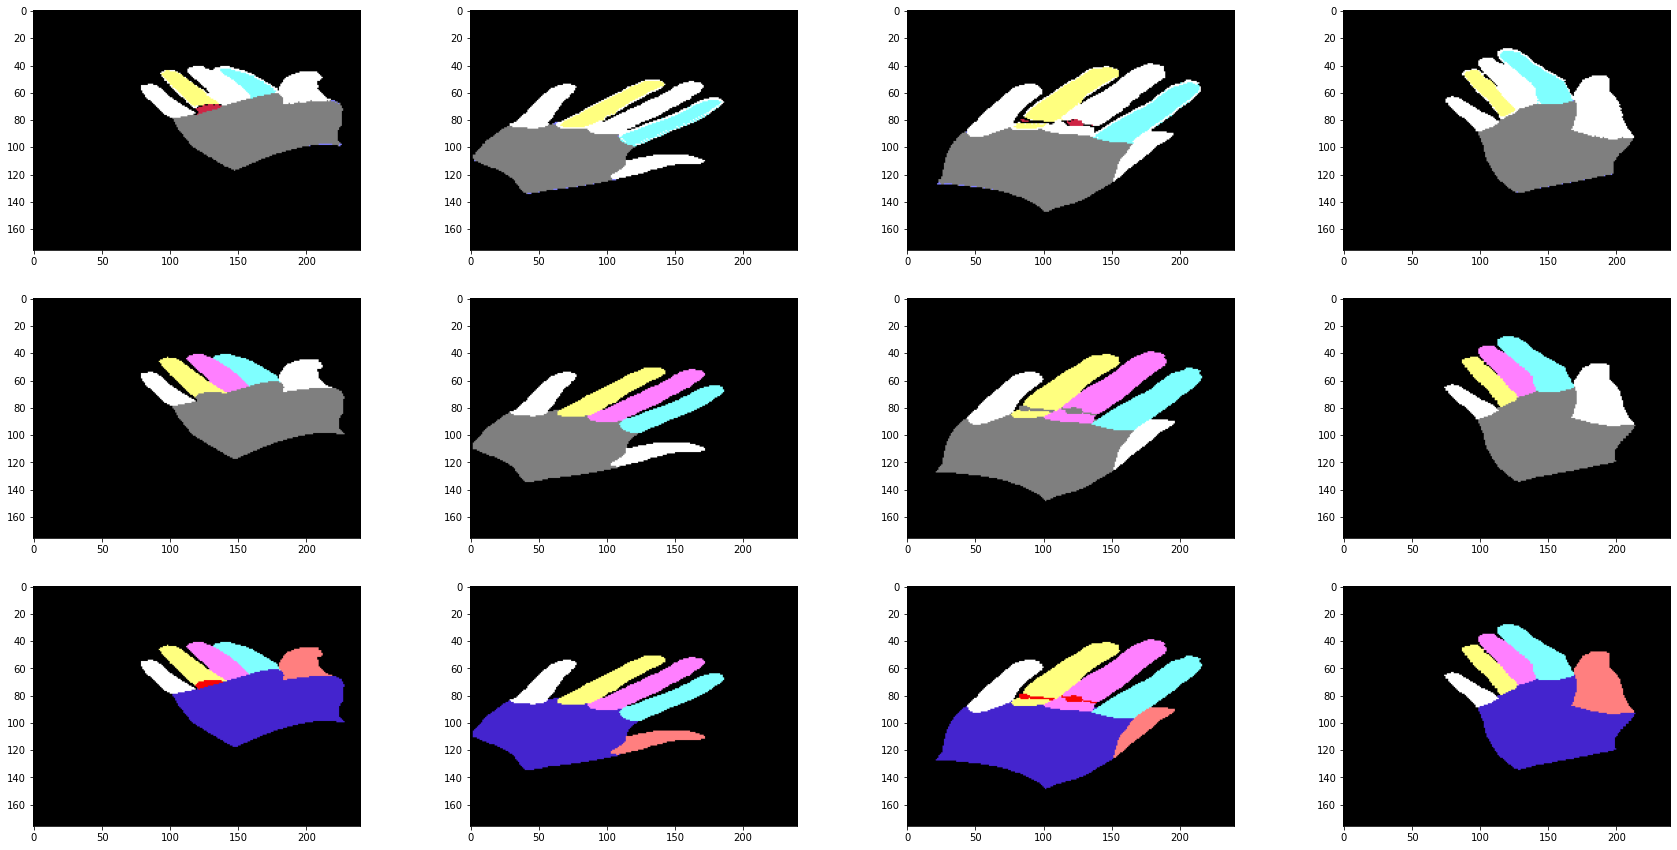

In [ ]:
processImage(modelL, 4, num_classes)

Вывод: сегментация сработала. Части тела руки помечены тем цветом, который я установил. Загружка данных прошла хорошо. Загрузка идет долго, поэтому такой батч-сайз, но все же результат хороший - до 85%.